
# Baseline — TF-IDF + One-vs-Rest LinearSVC (Multilabel)


Este notebook entrena un **baseline reproducible** para el reto de clasificación médica multilabel usando:
- **Entrada:** `title + abstract`
- **Features:** TF-IDF (unigramas + bigramas)
- **Modelo:** One-vs-Rest **LinearSVC**
- **Métricas:** Weighted F1 (principal), Exact Match Accuracy, reporte por clase y matrices de confusión multilabel


# Justificación del modelo
Elegimos TF-IDF + LinearSVC como baseline porque:
- TF-IDF es una representación eficiente para textos biomédicos sin necesidad de embeddings.
- LinearSVC maneja bien datos de alta dimensión y es rápido de entrenar.
- El esquema One-vs-Rest permite tratar el problema multilabel, entrenando un clasificador independiente por cada grupo médico.


## Configuración inicial

In [1]:
DATA_PATH = "../data/challenge_data-18-ago.csv"  
SEP = ";"                                     # Separador del CSV
SEED = 11                                     # Semilla para reproducibilidad
TEST_SIZE = 0.20                              # Proporción de datos para test
OUT_DIR = "../artifacts/baseline_tfidf_svm"


In [2]:

import re, time, json
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, multilabel_confusion_matrix

import joblib
import matplotlib.pyplot as plt


In [3]:

df = pd.read_csv(DATA_PATH, sep=SEP)
print("Shape:", df.shape)
df.head(4)


Shape: (3565, 3)


,title,abstract,group
0,Adrenoleukodystrophy: survey of 303 cases: bio...,Adrenoleukodystrophy ( ALD ) is a genetically ...,neurological|hepatorenal
1,endoscopy reveals ventricular tachycardia secrets,Research question: How does metformin affect c...,neurological
2,dementia and cholecystitis: organ interplay,Purpose: This randomized controlled study exam...,hepatorenal
3,The interpeduncular nucleus regulates nicotine...,Partial lesions were made with kainic acid in ...,neurological


## Procesamiento de texto

In [4]:

# Limpieza y normalización de texto
def normalize_text(x: str) -> str:
    if not isinstance(x, str):
        return ""
    return re.sub(r"\s+", " ", x).strip()

# Esto es lo que alimenta al modelo (se usa todo el texto, sin perder contexto).
df["text"] = (df["title"].fillna("") + " " + df["abstract"].fillna("")).map(normalize_text)

# Procesamiento de etiquetas
def parse_labels(val):
    if pd.isna(val):
        return []
    labs = re.split(r"[|;,/]", str(val))
    labs = [g.strip().lower() for g in labs if g and str(g).strip()]
    mapping = {
        "cardiovascular": "Cardiovascular",
        "neurological": "Neurological",
        "hepatorenal": "Hepatorenal",
        "oncological": "Oncological",
    }
    out = [mapping[g] for g in labs if g in mapping]
    seen=set(); uniq=[]
    for g in out:
        if g not in seen:
            seen.add(g); uniq.append(g)
    return uniq

df["labels"] = df["group"].apply(parse_labels)
df = df[df["labels"].map(len) > 0].reset_index(drop=True)

print("Registros con ≥1 etiqueta válida:", len(df))
df[["title","abstract","group","labels"]].head(3)


Registros con ≥1 etiqueta válida: 3565


,title,abstract,group,labels
0,Adrenoleukodystrophy: survey of 303 cases: bio...,Adrenoleukodystrophy ( ALD ) is a genetically ...,neurological|hepatorenal,"[Neurological, Hepatorenal]"
1,endoscopy reveals ventricular tachycardia secrets,Research question: How does metformin affect c...,neurological,[Neurological]
2,dementia and cholecystitis: organ interplay,Purpose: This randomized controlled study exam...,hepatorenal,[Hepatorenal]


## Binarización de etiquetas

In [5]:

mlb = MultiLabelBinarizer(classes=["Cardiovascular","Neurological","Hepatorenal","Oncological"])
Y = mlb.fit_transform(df["labels"])
dict(zip(mlb.classes_, Y.sum(axis=0).tolist()))


{'Cardiovascular': 1268,
 'Neurological': 1785,
 'Hepatorenal': 1091,
 'Oncological': 601}

## Separamos los datos en entrenamiento y prueba

In [6]:

primary_label = [labs[0] for labs in df["labels"]]
X_train, X_test, y_train, y_test, Y_train, Y_test = train_test_split(
    df["text"].values, primary_label, Y, test_size=TEST_SIZE, random_state=SEED, stratify=primary_label
)
len(X_train), len(X_test)


(2852, 713)

## Pipeline de modelado

### Construcción y entrenamiento del pipeline de clasificación multilabel

In [7]:

tfidf = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),
    max_df=0.95,
    min_df=2,
    max_features=50000,
    strip_accents="unicode",
    sublinear_tf=True
)

clf = OneVsRestClassifier(LinearSVC())

pipe = Pipeline([("tfidf", tfidf), ("clf", clf)])

start = time.time()
pipe.fit(X_train, Y_train)
print("Entrenamiento completado en %.2f s" % (time.time()-start))


Entrenamiento completado en 0.74 s


### Evaluación F1 Score

In [27]:

Y_pred = pipe.predict(X_test)
weighted_f1 = f1_score(Y_test, Y_pred, average="weighted", zero_division=0)
exact_match = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(f"Weighted F1: {weighted_f1:.4f}, Exact Match: {exact_match:.4f}")
report_df

Weighted F1: 0.8706, Exact Match: 0.7363


,precision,recall,f1-score,support
Cardiovascular,0.976744,0.820312,0.891720,256.0
Neurological,0.913545,0.887955,0.900568,357.0
Hepatorenal,0.988095,0.744395,0.849105,223.0
Oncological,0.988889,0.654412,0.787611,136.0
micro avg,0.953659,0.804527,0.872768,972.0
macro avg,0.966818,0.776769,0.857251,972.0
weighted avg,0.957835,0.804527,0.870626,972.0
samples avg,0.947405,0.859864,0.884525,972.0


El Weighted F1 obtenido refleja el rendimiento general ponderado por frecuencia de clase. 
Esto es apropiado para nuestro dataset desbalanceado, ya que clases más frecuentes como 
Cardiovascular tienen mayor peso en la métrica final.

La Exact Match Accuracy es baja, lo cual es esperado en multilabel, pues exige predecir 
todas las etiquetas correctas al mismo tiempo. Sin embargo, el modelo demuestra 
capacidad razonable en detectar al menos la etiqueta principal.

- Estos números son del baseline reproducido en notebooks; se espera mejora con ensembles/transformers y calibración de umbrales.

## Guardamos resultados

In [9]:

out_dir = Path(OUT_DIR)
out_dir.mkdir(parents=True, exist_ok=True)
report_df.to_csv(out_dir/"classification_report.csv")
with open(out_dir/"metrics.json","w") as f:
    json.dump({"weighted_f1":float(weighted_f1),"exact_match_accuracy":float(exact_match)}, f, indent=2)


### Matrices de confusión multilabel

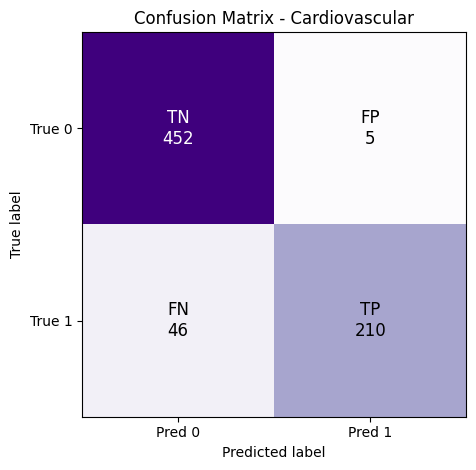

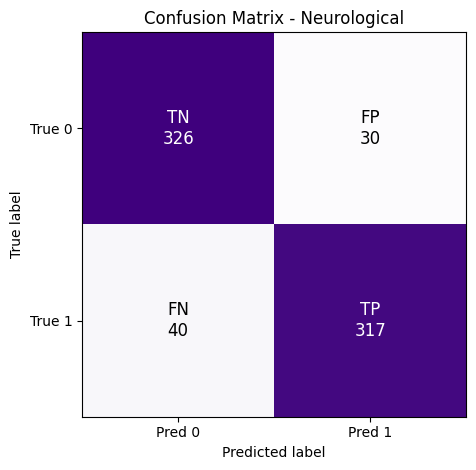

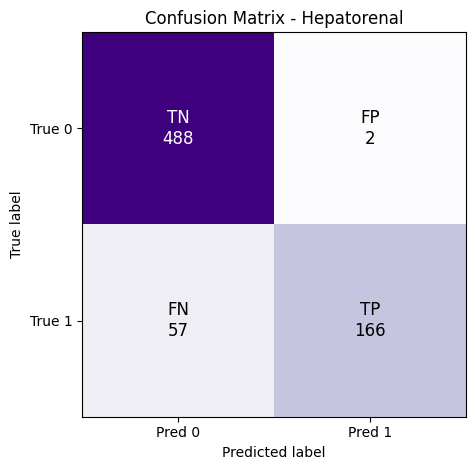

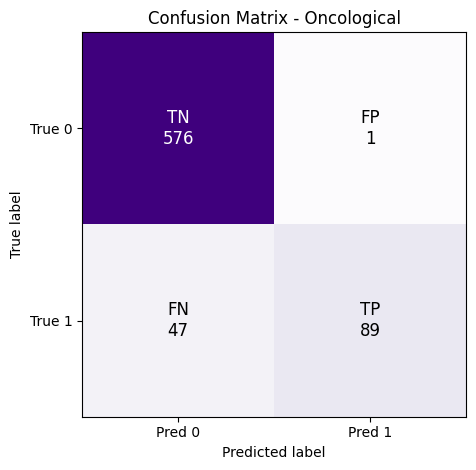

In [28]:
cm_dir = out_dir / "confusion_matrices"
cm_dir.mkdir(exist_ok=True)
ml_cm = multilabel_confusion_matrix(Y_test, Y_pred)
corner_labels = [["TN", "FP"], ["FN", "TP"]]

for i, label in enumerate(mlb.classes_):
    tn, fp, fn, tp = ml_cm[i].ravel()
    cm = np.array([[tn, fp], [fn, tp]])
    pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Pred 0", "Pred 1"]).to_csv(cm_dir / f"cm_{label}.csv")
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(cm, cmap=plt.cm.Purples)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])
    ax.set_title(f"Confusion Matrix - {label}")
    
    # Etiquetas TN, FP, FN, TP en cada celda
    for (r, c), val in np.ndenumerate(cm):
        ax.text(c, r, f"{corner_labels[r][c]}\n{val}", ha='center', va='center', fontsize=12,
                color="white" if val > cm.max()/2 else "black")
    
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.tight_layout()
    plt.show()  # Muestra la gráfica en el notebook
    
    fig.savefig(cm_dir / f"cm_{label}.png", dpi=140, bbox_inches="tight")
    plt.close(fig)

### Interpretación de los datos

**Cardiovascular**
- TP = 210, FN = 46, FP = 5, TN = 452
- Precision = 97.7%
- Recall = 82.0%
- Buen recall, aunque hay 46 falsos negativos. El modelo detecta bien esta clase, pero aún se le escapan algunos casos.

**Neurological**
- TP = 317, FN = 40, FP = 30, TN = 326
- Precision = 91.3%
- Recall = 88.8%
- Muy buen recall: el modelo detecta la mayoría de los textos neurológicos.
- El número de falsos positivos es el más alto entre todas las clases (30), lo que sugiere que el modelo tiende a sobredetectar esta clase, posiblemente por patrones compartidos con otras etiquetas.

**Oncological**
- TP = 89, FN = 47, FP = 1, TN = 576
- Precision = 98.9%
- Recall = 65.4%
- Pero el recall es bajo: más de un tercio de los textos oncológicos no son detectados. Esto indica que el modelo es conservador con esta clase, y podría estar perdiendo casos sutiles o con vocabulario menos típico.

**Hepatorenal**
- TP = 166, FN = 57, FP = 2, TN = 488
- Precision = 98.8%
- Recall = 74.4%
- El recall es moderado: hay una cantidad considerable de falsos negativos. El modelo detecta bien esta clase cuando lo hace, pero se le escapan bastantes casos.

En genereal la precisión del modelo por categoría es buena.

### Guardamos el modelo

In [11]:

model_path = out_dir/"model.joblib"
joblib.dump({"pipeline":pipe,"mlb":mlb},model_path)
print("Modelo guardado en", model_path)


Modelo guardado en ..\artifacts\baseline_tfidf_svm\model.joblib


### Función de predicción (DEMO)

In [12]:

def predict_labels(texts):
    if isinstance(texts,str):
        texts=[texts]
    preds=pipe.predict(texts)
    results=[]
    for row in preds:
        labels=[mlb.classes_[i] for i,v in enumerate(row) if v==1]
        results.append(labels)
    return results

demo_text=df.iloc[0]["text"]
print("Texto:", demo_text[:200],"...")
print("Predicción:",predict_labels(demo_text))


Texto: Adrenoleukodystrophy: survey of 303 cases: biochemistry, diagnosis, and therapy. Adrenoleukodystrophy ( ALD ) is a genetically determined disorder associated with progressive central demyelination and ...
Predicción: [['Neurological', 'Hepatorenal']]


## Interpretaciones de los resultados

- El **Weighted F1** obtenido representa el rendimiento global ponderado por el soporte de cada clase.  
  Esto significa que las clases más frecuentes, como *Neurological* o *Cardiovascular*, tienen mayor impacto en la métrica final.  

- La **Exact Match Accuracy** resultó significativamente más baja, lo cual es **esperado en problemas multilabel**: para acertar se deben predecir todas las etiquetas correctas a la vez, sin omitir ni añadir ninguna.

- El **reporte por clase** muestra que categorías con menor representación, como *Oncological*, tienden a tener menor recall, lo que confirma la necesidad de manejar el desbalance de clases.

- Las **matrices de confusión multilabel** indican que algunos errores frecuentes provienen de falsos negativos en artículos que combinan varias categorías (ejemplo: *Neurological + Hepatorenal*). Esto sugiere que el modelo aún no captura bien las co-ocurrencias de etiquetas.

## Conclusión general  
Este modelo baseline será nuestra **línea de referencia oficial**, con métricas reproducibles y artefactos guardados.  
Cualquier mejora futura deberá **superar este Weighted F1** para justificar su adopción.